## Identify the synthetic lethal interaction by outlier statistics *-- ROC and PR Analysis*

We would identify the paralog pairs as SLs based on outlier statistics. If the A1 gene dependency scores of the A2 gene with HD (standard Z-score, robust Z-score, or ranking) are identified as outlier, this A1-A2 candidate pair is defined as SL. 

The pairs identified in combinatorial screens done via experimental approach are used as validation dataset.

**Input**
- Integrated dataset (contain A1, A2 information, A2 CNV, A1 gene dependency scores): HUGE_dataset.csv
- Combinatorial validation dataset: all_screened_paralog_pairs_22_03_23.xlsx

**Output**
- ROC curve

In [3]:
## Import modules
import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score

import seaborn as sns
import matplotlib.pyplot as plt

### Validation data

Two types of validation data and we will use consensus.
- All screened pairs
- Consensus pairs

In [4]:
## Load dataset
comb_df = pd.read_excel('/Users/amy/Desktop/SyntheticLethalityProject/sources/all_screened_paralog_pairs_22_03_23.xlsx', index_col=False)
comb_df = comb_df[['sorted_gene_pair', 'A1', 'A2', 'A1_ensembl', 'A2_ensembl', 'n_screens_tested', 'n_screens_SL']]
comb_df[:2]

,sorted_gene_pair,A1,A2,A1_ensembl,A2_ensembl,n_screens_tested,n_screens_SL
0,A2M_PZP,A2M,PZP,ENSG00000175899,ENSG00000126838,1,0
1,A3GALT2_ABO,A3GALT2,ABO,ENSG00000184389,ENSG00000175164,1,0


**Consensus pairs**

TPs = Paralog pairs found to be hits in at least two studies (Dede/Thompson/Parrish/Chymera)

TNs = Pairs screened in at least two studies and not found to be hits in any study

In [5]:
consensus = comb_df.loc[comb_df['n_screens_tested'] >=2,:]
# all_screened_pairs_cp = all_screened_pairs
# consensus = all_screened_pairs_cp
pd.DataFrame(consensus).loc[:,'SL'] = consensus['n_screens_SL'] >=2

print('Consensus:', sum(consensus.SL),'/',consensus.shape[0])

consensus[:5]

Consensus: 86 / 969


,sorted_gene_pair,A1,A2,A1_ensembl,A2_ensembl,n_screens_tested,n_screens_SL,SL
4,AADAC_AADACL2,AADAC,AADACL2,ENSG00000114771,ENSG00000197953,2,0,False
11,AADACL3_AADACL4,AADACL3,AADACL4,ENSG00000188984,ENSG00000204518,2,0,False
18,ABCF1_ABCF3,ABCF1,ABCF3,ENSG00000204574,ENSG00000161204,2,0,False
20,ABHD12_ABHD12B,ABHD12,ABHD12B,ENSG00000100997,ENSG00000131969,2,0,False
22,ABHD4_ABHD5,ABHD4,ABHD5,ENSG00000100439,ENSG00000011198,3,0,False


### Testing data 

In [6]:
## Load dataset 
test_df = pd.read_csv('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/03_HUGE_dataset/HUGE_dataset.csv', index_col=False) 
test_df[:2]

,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,A2_hgnc_symbol,pairs_to_test,pairs_to_test_symbol,BROAD_ID,A2_CNV,A1_Chronosscore,A1_StandardZscore,A1_RobustZscore,A1_Ranking
0,ABL1_ABL2,ABL1,ABL2,25,27,ENSG00000097007,ENSG00000143322,ABL2,25-27,ABL1_ABL2,ACH-000948,Gain,0.052967,0.353450,0.492425,212.0
1,ABL1_ABL2,ABL1,ABL2,25,27,ENSG00000097007,ENSG00000143322,ABL2,25-27,ABL1_ABL2,ACH-000011,Neutral,-0.374167,-1.681954,-3.452557,692.0


### ROC curve

TPR = TP / (TP + FN)

FPR = FP / (TP + FN)

In [7]:
def plot_roc_curve(y_test, y_score, ax, color, y_score_label, fontsize):
    
    fpr, tpr, threshold = roc_curve(y_test, y_score, pos_label=True)
    auc = roc_auc_score(y_test, y_score)
    
    if y_score_label == 'standard Z-score':
        ax.plot(fpr, tpr, color=color, label='Standard Z-score (%0.3f)' % auc)
    elif y_score_label == 'robust Z-score':
        ax.plot(fpr, tpr, color=color, label='Robust Z-score (%0.3f)' % auc)
    elif y_score_label == 'ranking':
        ax.plot(fpr, tpr, color=color, label='Ranking (%0.3f)' % auc)
    elif y_score_label == 'Chronos score':
        ax.plot(fpr, tpr, color=color, label='Chronos (%0.3f)' % auc)

    
    ax.plot([0, 1], [0, 1], '--', color='grey', label = 'Chance (0.50)')
    
    ax.set_xlabel('False Positive Rate', fontsize = fontsize); ax.set_ylabel("True Positive Rate", fontsize = fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.legend(loc='lower right',fontsize=10, frameon=False)
    
    return ax, fpr, tpr, threshold

**Consensus pairs as validation data**

In [8]:
test_pair = set(test_df.sorted_gene_pair)
consensus_pair = set(consensus.sorted_gene_pair)
test_consensus_share = test_pair.intersection(consensus_pair)
test_consensus = test_df[test_df.sorted_gene_pair.isin(list(test_consensus_share))]
test_consensus[:2]

,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,A2_hgnc_symbol,pairs_to_test,pairs_to_test_symbol,BROAD_ID,A2_CNV,A1_Chronosscore,A1_StandardZscore,A1_RobustZscore,A1_Ranking
0,ABL1_ABL2,ABL1,ABL2,25,27,ENSG00000097007,ENSG00000143322,ABL2,25-27,ABL1_ABL2,ACH-000948,Gain,0.052967,0.353450,0.492425,212.0
1,ABL1_ABL2,ABL1,ABL2,25,27,ENSG00000097007,ENSG00000143322,ABL2,25-27,ABL1_ABL2,ACH-000011,Neutral,-0.374167,-1.681954,-3.452557,692.0


In [9]:
test_del = test_consensus[test_consensus['A2_CNV'] == 'Deletion']
# Keep the minimum score 
test_del_min = test_del.sort_values(by = ['pairs_to_test_symbol', 'A1_Chronosscore']).drop_duplicates(subset='pairs_to_test_symbol', keep='last')
test_valid_del = pd.merge(test_del_min, consensus[['sorted_gene_pair','SL']], on = ['sorted_gene_pair'], how='left')
test_valid_del = test_valid_del.dropna()
test_valid_del = test_valid_del.sort_values(by = ['sorted_gene_pair', 'SL'], ascending=False).drop_duplicates(subset='sorted_gene_pair', keep='first')
print('Consensus pairs:', sum(test_valid_del.SL),'/',test_valid_del.shape[0])

Consensus pairs: 24 / 138


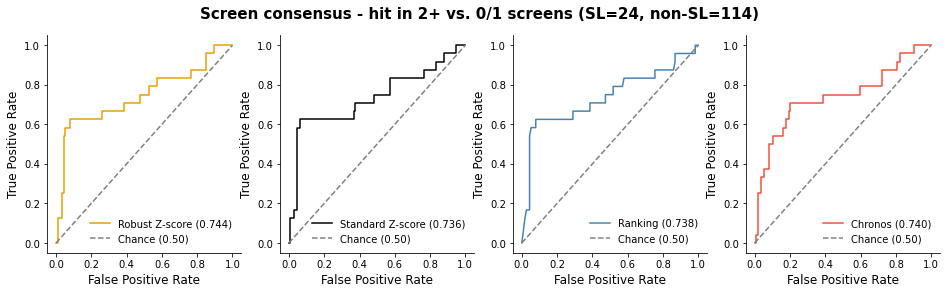

In [10]:
f, axes = plt.subplots(1,4, figsize=(16,4), gridspec_kw={'width_ratios': [1,1,1,1]})

plt.suptitle('Screen consensus - hit in 2+ vs. 0/1 screens (SL='+ str(sum(test_valid_del.SL))+', non-SL='+str(sum(~test_valid_del.SL))+')', 
             fontweight='bold', horizontalalignment='center', fontsize = 15)

ax1, fpr_rob, tpr_rob, threshold_rob = plot_roc_curve(test_valid_del['SL'], -test_valid_del['A1_RobustZscore'], axes[0],
                                                      '#E69F00', 'robust Z-score', 12)

ax2, fpr_stand, tpr_stand, threshold_stand = plot_roc_curve(test_valid_del['SL'], -test_valid_del['A1_StandardZscore'], axes[1],
                                                            'black', 'standard Z-score', 12)

ax3, fpr_r, tpr_r, threshold_r = plot_roc_curve(test_valid_del['SL'], test_valid_del['A1_Ranking'], axes[2],
                                                'steelblue', 'ranking', 12)

ax4, fpr_org, tpr_org, threshold_org = plot_roc_curve(test_valid_del['SL'], -test_valid_del['A1_Chronosscore'], axes[3],
                                                      '#F44E3B', 'Chronos score', 12)

## Threshold 
# optimal_idx = np.argmax(tpr_rob - fpr_rob)
# optimal_threshold = threshold_rob[optimal_idx]
# print("Optimal threshold for robust Z-score is:", -optimal_threshold)

## Save figure 
f.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/04_identify_SL_interaction_roc/consensus_roc.pdf', dpi=400, bbox_inches='tight')

### Precision-recall curve

Recall (sensitivity) = TP / (TP + FN)

Precision = TP / (TP + FP) = 1 - FDR = 1 - [FP / (TP + FP)]

In [11]:
def plot_pr_curve(y_test, y_score, ax, color, y_score_label, fontsize, trim = False):
    
    prec, recall, threshold  = precision_recall_curve(y_test, y_score, pos_label=True)
    avg_prec = average_precision_score(y_test, y_score)
    
    if trim: prec = prec[:-1]; recall = recall[:-1]
    
    if y_score_label == 'standard Z-score':
        ax.plot(recall, prec, color=color, label='Standard Z-score (%0.3f)' % avg_prec)
    elif y_score_label == 'robust Z-score':
        ax.plot(recall, prec, color=color, label='Robust Z-score (%0.3f)' % avg_prec)
    elif y_score_label == 'ranking':
        ax.plot(recall, prec, color=color, label='Ranking (%0.3f)' % avg_prec)
    elif y_score_label == 'Chronos score':
        ax.plot(recall, prec, color=color, label='Chronos (%0.3f)' % avg_prec)
   
    P = sum(test_valid_del.SL)
    N = test_valid_del.shape[0]
    baseline = P/N
    
    ax.plot([0, 1], [P/N, P/N], '--', color='grey', label = 'Chance (%0.3f)' % baseline)
    
    ax.set_xlabel('Recall', fontsize = fontsize); ax.set_ylabel("Precision", fontsize = fontsize)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.legend(loc='upper right',fontsize=10, frameon=False)
    
    return ax, prec, recall, threshold

Min threshold for >=70% precision (Standard Z-score) -1.4920864894763868
Max recall for >=70% precision (Standard Z-score) 0.5833333333333334


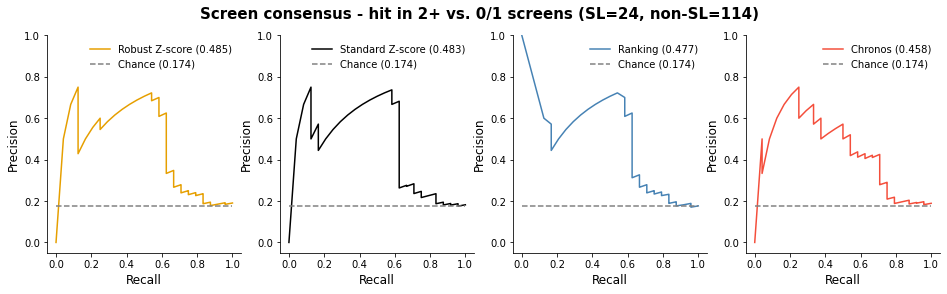

In [12]:
f, axes = plt.subplots(1,4, figsize=(16,4), gridspec_kw={'width_ratios': [1,1,1,1]})

plt.suptitle('Screen consensus - hit in 2+ vs. 0/1 screens (SL='+ str(sum(test_valid_del.SL))+', non-SL='+str(sum(~test_valid_del.SL))+')', 
              fontweight='bold', horizontalalignment='center', fontsize = 15)

ax1, prec_rob, recall_rob, threshold_rob = plot_pr_curve(test_valid_del['SL'], -test_valid_del['A1_RobustZscore'], axes[0],
                                                         '#E69F00', 'robust Z-score', 12, trim=True)
ax1.set_ylim(-0.05,1)


ax2, prec_stand, recall_stand, threshold_stand = plot_pr_curve(test_valid_del['SL'], -test_valid_del['A1_StandardZscore'], axes[1],
                                                               'black', 'standard Z-score', 12, trim=True)
ax2.set_ylim(-0.05,1)


ax3, prec_r, recall_r, threshold_r = plot_pr_curve(test_valid_del['SL'], test_valid_del['A1_Ranking'], axes[2],
                                                   'steelblue', 'ranking', 12)
ax3.set_ylim(-0.05,1)


ax4, prec_org, recall_org, threshold_org = plot_pr_curve(test_valid_del['SL'], -test_valid_del['A1_Chronosscore'], axes[3],
                                                         '#F44E3B', 'Chronos score', 12, trim=True)
ax4.set_ylim(-0.05,1)


## Threshold 
# optimal_idx = np.argmax(tpr_rob - fpr_rob)
# optimal_threshold = threshold_rob[optimal_idx]
# print("Optimal threshold for robust Z-score is:", -optimal_threshold)

print('Min threshold for >=70% precision (Standard Z-score)', -threshold_stand[np.argwhere((prec_stand >= 0.7) & (prec_stand != 1)).min()])
print('Max recall for >=70% precision (Standard Z-score)', recall_stand[np.argwhere((prec_stand >= 0.70) & (prec_stand != 1)).min()])

## Save figure 
f.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/04_identify_SL_interaction_roc/consensus_pr.pdf', dpi=400, bbox_inches='tight')

**All screened pairs *(just for investigation)***

In [13]:
all_screened_pairs = comb_df
# all_screened_pairs_cp = all_screened_pairs
# consensus = all_screened_pairs_cp
pd.DataFrame(all_screened_pairs).loc[:,'SL'] = all_screened_pairs['n_screens_SL'] >=1

print('all_screened_pairs:', sum(all_screened_pairs.SL),'/',all_screened_pairs.shape[0])

all_screened_pairs[:1]

all_screened_pairs: 444 / 5832


,sorted_gene_pair,A1,A2,A1_ensembl,A2_ensembl,n_screens_tested,n_screens_SL,SL
0,A2M_PZP,A2M,PZP,ENSG00000175899,ENSG00000126838,1,0,False


In [14]:
test_pair = set(test_df.sorted_gene_pair)
all_pair = set(all_screened_pairs.sorted_gene_pair)
test_all_share = test_pair.intersection(all_pair)
test_all = test_df[test_df.sorted_gene_pair.isin(list(test_all_share))]

In [15]:
test_del = test_all[test_all['A2_CNV'] == 'Deletion']
# test_del_cp = test_del[['pairs_to_test_symbol', 'A1_Chronosscore']]
## For the duplicated samples, only keep the samples with lowest Z-score
# test_del_min = test_del_cp.groupby(['pairs_to_test_symbol'])['A1_Chronosscore'].min().reset_index()
test_del_min = test_del.sort_values(by = ['pairs_to_test_symbol', 'A1_Chronosscore']).drop_duplicates(subset='pairs_to_test_symbol', keep='last')
# test_del = pd.merge(test_del_min, test_del[['pairs_to_test_symbol', 'sorted_gene_pair','A1_StandardZscore', 'A1_RobustZscore', 'A1_Ranking']], on = ['pairs_to_test_symbol'], how = 'left').drop_duplicates(subset=['sorted_gene_pair'])

test_valid_del = pd.merge(test_del_min, all_screened_pairs[['sorted_gene_pair','SL']], on = ['sorted_gene_pair'], how='left')
test_valid_del = test_valid_del.dropna()
test_valid_del = test_valid_del.sort_values(by = ['sorted_gene_pair', 'SL'], ascending=False).drop_duplicates(subset='sorted_gene_pair', keep='first')
print('All screened pairs:', sum(test_valid_del.SL),'/',test_valid_del.shape[0])

All screened pairs: 53 / 237


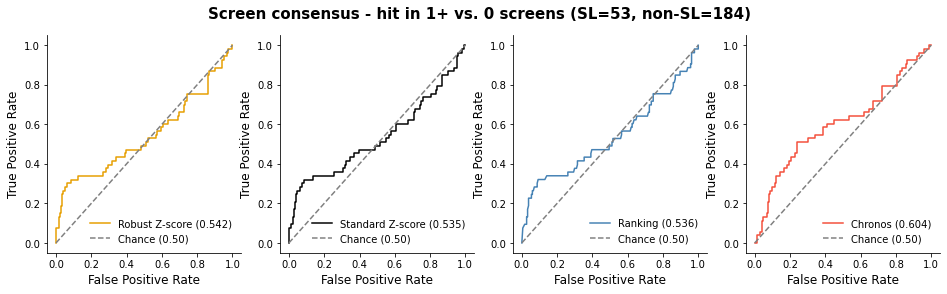

In [17]:
f, axes = plt.subplots(1,4, figsize=(16,4), gridspec_kw={'width_ratios': [1,1,1,1]})

f.suptitle('Screen consensus - hit in 1+ vs. 0 screens (SL='+ str(sum(test_valid_del.SL))+', non-SL='+str(sum(~test_valid_del.SL))+')', 
             fontweight='bold', horizontalalignment='center', fontsize = 15)

ax1, fpr_rob, tpr_rob, threshold_rob = plot_roc_curve(test_valid_del['SL'], -test_valid_del['A1_RobustZscore'], axes[0],
                                                      '#E69F00', 'robust Z-score', 12)

ax2, fpr_stand, tpr_stand, threshold_stand = plot_roc_curve(test_valid_del['SL'], -test_valid_del['A1_StandardZscore'], axes[1],
                                                            'black', 'standard Z-score', 12)

ax3, fpr_r, tpr_r, threshold_r = plot_roc_curve(test_valid_del['SL'], test_valid_del['A1_Ranking'], axes[2],
                                                'steelblue', 'ranking', 12)

ax4, fpr_org, tpr_org, threshold_org = plot_roc_curve(test_valid_del['SL'], -test_valid_del['A1_Chronosscore'], axes[3],
                                                      '#F44E3B', 'Chronos score', 12)

                                              

## Threshold 
# optimal_idx = np.argmax(tpr_rob - fpr_rob)
# optimal_threshold = threshold_rob[optimal_idx]
# print("Optimal threshold for robust Z-score is:", -optimal_threshold)

## Save figure 
f.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/04_identify_SL_interaction_roc/all_screened_pairs_roc.pdf', dpi=400, bbox_inches='tight')

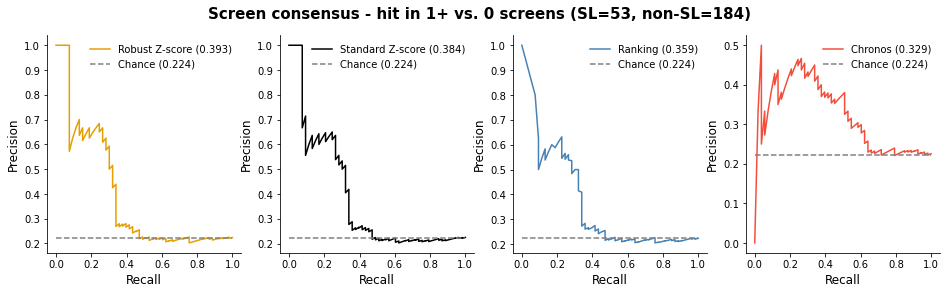

In [18]:
f, axes = plt.subplots(1,4, figsize=(16,4), gridspec_kw={'width_ratios': [1,1,1,1]})

f.suptitle('Screen consensus - hit in 1+ vs. 0 screens (SL='+ str(sum(test_valid_del.SL))+', non-SL='+str(sum(~test_valid_del.SL))+')', 
             fontweight='bold', horizontalalignment='center', fontsize = 15)

ax1, prec_rob, recall_rob, threshold_rob = plot_pr_curve(test_valid_del['SL'], -test_valid_del['A1_RobustZscore'], axes[0],
                                                         '#E69F00', 'robust Z-score', 12)

ax2, prec_stand, recall_stand, threshold_stand = plot_pr_curve(test_valid_del['SL'], -test_valid_del['A1_StandardZscore'], axes[1],
                                                               'black', 'standard Z-score', 12)

ax3, prec_r, recall_r, threshold_r = plot_pr_curve(test_valid_del['SL'], test_valid_del['A1_Ranking'], axes[2],
                                                   'steelblue', 'ranking', 12)

ax4, prec_org, recall_org, threshold_org = plot_pr_curve(test_valid_del['SL'], -test_valid_del['A1_Chronosscore'], axes[3],
                                                         '#F44E3B', 'Chronos score', 12, trim=True)


f.savefig('/Users/amy/Desktop/SyntheticLethalityProject/2_data_analysis/04_identify_SL_interaction_roc/all_screened_pairs_pr.pdf', dpi=400, bbox_inches='tight')

In [19]:
## Boxplot for 52 SL Z-score
plot_df = pd.DataFrame(test_valid_del)
test_valid_del[:5]

,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,A2_hgnc_symbol,pairs_to_test,pairs_to_test_symbol,BROAD_ID,A2_CNV,A1_Chronosscore,A1_StandardZscore,A1_RobustZscore,A1_Ranking,SL
260,ZNF600_ZNF611,ZNF600,ZNF611,162966,81856,ENSG00000189190,ENSG00000213020,ZNF611,162966-81856,ZNF600_ZNF611,ACH-000621,Deletion,0.207140,1.267541,1.318880,66.0,False
259,ZNF175_ZNF81,ZNF175,ZNF81,7728,347344,ENSG00000105497,ENSG00000197779,ZNF81,7728-347344,ZNF175_ZNF81,ACH-000970,Deletion,0.107349,0.587225,0.698634,161.0,False
258,ZFAND5_ZFAND6,ZFAND6,ZFAND5,54469,7763,ENSG00000086666,ENSG00000107372,ZFAND5,54469-7763,ZFAND6_ZFAND5,ACH-000009,Deletion,0.075586,0.452489,0.451239,224.0,False
257,ZEB1_ZEB2,ZEB1,ZEB2,6935,9839,ENSG00000148516,ENSG00000169554,ZEB2,6935-9839,ZEB1_ZEB2,ACH-000665,Deletion,-0.239161,-0.988960,-1.602267,610.0,False
256,ZDHHC5_ZDHHC8,ZDHHC8,ZDHHC5,29801,25921,ENSG00000099904,ENSG00000156599,ZDHHC5,29801-25921,ZDHHC8_ZDHHC5,ACH-000491,Deletion,-0.000711,1.822155,1.949152,23.0,False


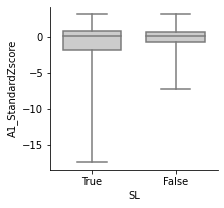

In [20]:
f, ax = plt.subplots(1, 1, figsize=(3,3))

# All tested pairs 
ax = sns.boxplot(x = "SL", y = "A1_StandardZscore", palette = ['#CCCCCC', '#CCCCCC'], data = plot_df, 
                 whis = [0,100], ax = ax, width = 0.7, order = [True, False])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

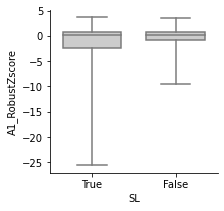

In [21]:
f, ax = plt.subplots(1, 1, figsize=(3,3))
ax = sns.boxplot(x = "SL", y = "A1_RobustZscore", palette = ['#CCCCCC', '#CCCCCC'], data = plot_df, 
                 whis = [0,100], ax = ax, width = 0.7, order = [True, False])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)